# Table of Contents

* [Initialization](#Initialization)
	* [Constants](#Constants)
		* [Dataset](#Dataset)
		* [MyMediaLite](#MyMediaLite)
		* [Experiments](#Experiments)
		* [Viz](#Viz)
	* [Prepare data](#Prepare-data)
	* [Prepare models](#Prepare-models)
	* [Set evaluation parameters](#Set-evaluation-parameters)
* [Run experiments](#Run-experiments)
* [Visualize results](#Visualize-results)
	* [Predictions from single negative feedback](#Predictions-from-single-negative-feedback)
	* [Predictions for "known" user](#Predictions-for-"known"-user)

In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from polara import (SVDModel, PopularityModel, RandomModel,
                    RecommenderData, get_movielens_data)
from polara.recommender.models import CoffeeModel
from polara.evaluation import evaluation_engine as ee
from polara.tools.preprocessing import filter_sessions_by_length
from polara.evaluation.plotting import show_hit_rates, show_precision_recall, show_ranking

# Initialization

## Constants

### Dataset

In [2]:
DATA_NAME = 'ml-1m'
DATA_FILE = 'D:/datasets/recsys/movielens/{}.zip'.format(DATA_NAME)#path to Movielens-1M zip-file
                                      #set it to None to automatically download data from Grouplens
SESS_SIZE = 20

## Prepare data

In [3]:
ml_data = get_movielens_data(local_file=DATA_FILE, get_genres=False)

In [4]:
ml_data = filter_sessions_by_length(ml_data, min_session_length=SESS_SIZE)
data_model = RecommenderData(ml_data, 'userid', 'movieid', 'rating', seed = 0)
data_model.name = DATA_NAME

In [5]:
data_model.get_configuration()

{'test_ratio': 0.2,
 'test_sample': None,
 'random_holdout': False,
 'permute_tops': False,
 'negative_prediction': False,
 'shuffle_data': False,
 'warm_start': True,
 'test_fold': 5,
 'holdout_size': 3}

## Prepare models

In [6]:
svd = SVDModel(data_model)
popular = PopularityModel(data_model)
random = RandomModel(data_model, seed=0)
coffee = CoffeeModel(data_model)

In [7]:
coffee.flattener = [3, 4] # ratings 4 and 5

In [8]:
models = [svd, coffee, popular, random]
model_names = [model.method for model in models]
model_names

['PureSVD', 'CoFFee', 'MP', 'RND']

In [9]:
for model in models:
    model.switch_positive = 4

In [10]:
for model in models:
    try:
        rank = model.rank
    except AttributeError:
        try:
            rank = model.mlrank
        except AttributeError:
            continue
    print('{} rank: {}'.format(model.method, rank))

PureSVD rank: 10
CoFFee rank: (13, 10, 2)


## Set evaluation parameters

In [11]:
metrics = ['ranking', 'relevance', 'experience']
topk_list = [1, 2, 3, 5, 10, 15, 20, 30, 50, 70, 100]
test_samples = [0, -1]
folds = [1, 2, 3, 4, 5]

In [12]:
data_model.holdout_size = 10
data_model.random_holdout = True

# Run experiments

In [13]:
result = {}
for test_sample in test_samples:
    data_model.test_sample = test_sample
    result[test_sample] = ee.run_cv_experiment(models,
                                               folds,
                                               metrics,
                                               fold_experiment=ee.topk_test,
                                               topk_list=topk_list)

Preparing data...
23 unique movieid's within 27 testset interactions were filtered. Reason: not in the training data.
1 unique movieid's within 1 holdout interactions were filtered. Reason: not in the training data.
1 of 1208 userid's were filtered out from holdout. Reason: incompatible number of items.
1 userid's were filtered out from testset. Reason: inconsistent with holdout.
Done.
There are 803312 events in the training and 12070 events in the holdout.
PureSVD training time: 0.104s
CoFFee training time: 3.544s
Preparing data...
47 unique movieid's within 56 testset interactions were filtered. Reason: not in the training data.
2 unique movieid's within 2 holdout interactions were filtered. Reason: not in the training data.
2 of 1208 userid's were filtered out from holdout. Reason: incompatible number of items.
2 userid's were filtered out from testset. Reason: inconsistent with holdout.
Done.
There are 792890 events in the training and 12060 events in the holdout.
PureSVD training 

In [14]:
test_sample = 0

In [15]:
scores = result[test_sample].mean(axis=0, level=['top-n', 'model'])
deviation = result[test_sample].std(axis=0, level=['top-n', 'model'])

In [16]:
scores['ranking'].unstack('model')

metric      nDCG                                    nDCL                      \
model     CoFFee        MP   PureSVD       RND    CoFFee        MP   PureSVD   
top-n                                                                          
1       0.070532  0.034049  0.077220  0.000463  0.019687  0.021976  0.026973   
2       0.099847  0.049284  0.111342  0.000805  0.030107  0.031109  0.040239   
3       0.118388  0.057795  0.132601  0.000989  0.038499  0.037549  0.051971   
5       0.143842  0.070335  0.159641  0.001398  0.050786  0.048499  0.069481   
10      0.179879  0.091356  0.197528  0.002269  0.074132  0.064922  0.101178   
15      0.201091  0.105611  0.219348  0.002940  0.090331  0.077387  0.122217   
20      0.216314  0.116623  0.234971  0.003573  0.104698  0.086674  0.139544   
30      0.238373  0.130844  0.256997  0.004453  0.127263  0.101282  0.166981   
50      0.265625  0.151501  0.284766  0.006308  0.158359  0.125126  0.205027   
70      0.282639  0.164905  0.302296  0.007902  0.182479  0.143222  0.230614   
100     0.300352  0.180364  0.319825  0.010240  0.208954  0.165874  0.262407   

metric            
model        RND  
top-n             
1       0.001412  
2       0.001739  
3       0.002081  
5       0.002621  
10      0.004211  
15      0.005838  
20      0.006509  
30      0.008315  
50      0.011740  
70      0.014341  
100     0.018518

# Visualize results

In [17]:
ERR_ALPHA = 0.1

## Predictions for "known" user

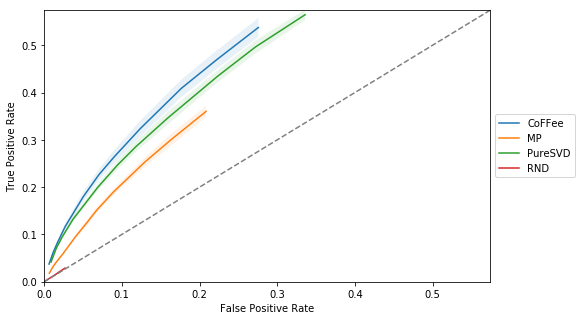

In [18]:
show_hit_rates(scores, errors=deviation, err_alpha=ERR_ALPHA)

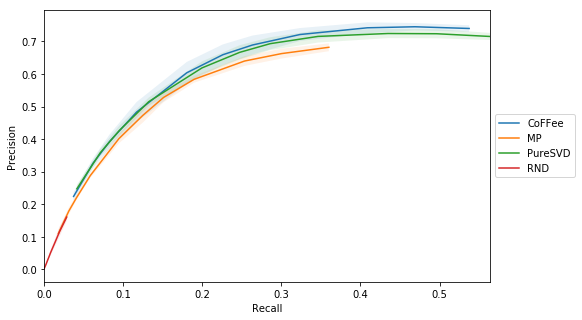

In [19]:
show_precision_recall(scores, errors=deviation, err_alpha=ERR_ALPHA)

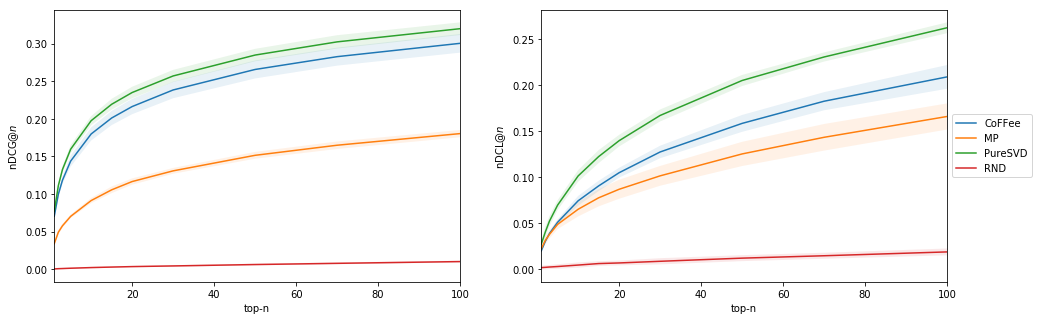

In [20]:
show_ranking(scores, errors=deviation, err_alpha=ERR_ALPHA)

## Predictions from single negative feedback

In [21]:
test_sample = -1

In [22]:
scores = result[test_sample].mean(axis=0, level=['top-n', 'model'])
deviation = result[test_sample].std(axis=0, level=['top-n', 'model'])

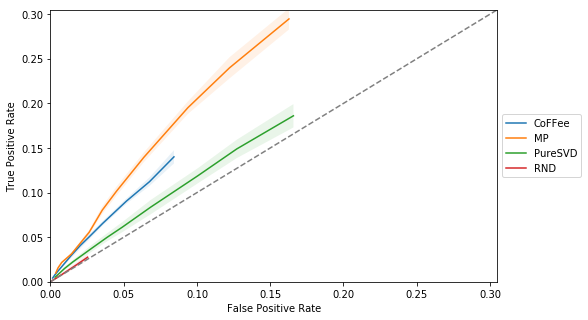

In [23]:
show_hit_rates(scores, errors=deviation, err_alpha=ERR_ALPHA)

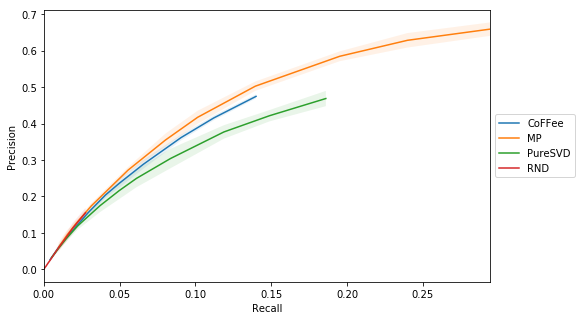

In [24]:
show_precision_recall(scores, errors=deviation, err_alpha=ERR_ALPHA)

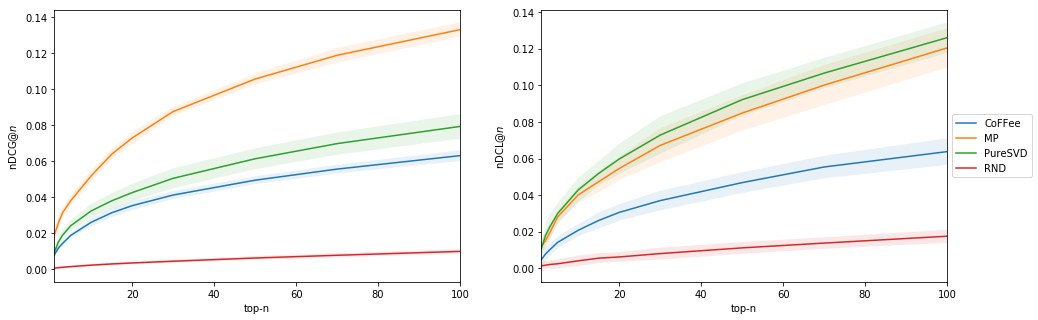

In [25]:
show_ranking(scores, errors=deviation, err_alpha=ERR_ALPHA)